Write-up

Buisness problem-
The buisness problem we will be answering with this code is will my first round draft pick underperform? Teams are making a huge investment selecting these players. A wrong pick can spell doom for a franchise so making sure you atleast get some value is essential.

Analytic problem- 
We will be using a supervised approach and a logistic regression model to handle this problem. We wish to use these to gain insight on how we evaluate draft picks. We will examine their college statitics to see which crititcal elements seperate performers and under-performers. 

Datasets-
We will use the NBA API, College refrence, and T-rank as our datasets to answer our buisness problem.


Modeling approach- We will use Logistic regression to find out wheter they are a performer or under-performer. Since there is no binary variable for this we will first use NBA stats of players to determine this. After we do this we will add that column to our College dataset and begin our model. 

Training/Testing/splitting- We will use stratfiedKfold to split our model because we already know our classes are imbalanced. We tried to use train/test/split before and using class_weight balanced before but it made our model very bad at picking up the 1's. Using StratifiedKfold our model is really good at picking up 1's.


Tuning- 
We tuned our hyperparameters using randomsearchcv. This goes through several options till it get the best matchup of hyperparameters. 

Conclusion- Our models accuracy was 70% which seems good because the NBA is a volitile climates. Also College Basketball and NBA BAsketball arent the same thing. The way some players play the game in college doesnt correlate to the big league and vice versa. Taking all that and player development we are happy with the accuracy and even more happy the model is good at picking up type-2 errors. Type-1 errors are a happy suprise for a team because it would be a false non-performer. In the future it'd be better to move back farther in the future giving newer players more seasons to develop before classifying them. Using this model teams can see their pick is low risk if they score a 1 on our model


In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import nba_api
from nba_api.stats.endpoints import playercareerstats, drafthistory, cumestatsplayer, playercareerbycollege
from nba_api.stats.static import players, teams
from nba_api.stats.library.parameters import PerMode36
from sklearn.model_selection import  RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import  accuracy_score, confusion_matrix,roc_curve, auc

from sklearn.preprocessing import StandardScaler



# pandas data frames (optional: pip install pandas)



Input your path to the excel sheet of college stats here. We will use this later in the code.

In [4]:
project_excel = '/Users/suber/OneDrive/Documents/Repo/DRAFT_PICKS_C_STATS.xlsx'

Testing out the api's capablities. Making sure i can use player_id to pull their names. We will use this function later on.

In [5]:
players.find_player_by_id(76001).get('full_name')

'Alaa Abdelnaby'

This extracts all of the NBA's draft and stores it into the variable drafth.

In [6]:
drafth= drafthistory.DraftHistory()
drafth.get_data_frames()[0]


,PERSON_ID,PLAYER_NAME,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK,DRAFT_TYPE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,ORGANIZATION,ORGANIZATION_TYPE,PLAYER_PROFILE_FLAG
0,1641705,Victor Wembanyama,2023,1,1,1,Draft,1610612759,San Antonio,Spurs,SAS,Metropolitans 92 (France),Other Team/Club,1
1,1641706,Brandon Miller,2023,1,2,2,Draft,1610612766,Charlotte,Hornets,CHA,Alabama,College/University,1
2,1630703,Scoot Henderson,2023,1,3,3,Draft,1610612757,Portland,Trail Blazers,POR,Ignite (G League),Other Team/Club,1
3,1641708,Amen Thompson,2023,1,4,4,Draft,1610612745,Houston,Rockets,HOU,Overtime Elite,Other Team/Club,1
4,1641709,Ausar Thompson,2023,1,5,5,Draft,1610612765,Detroit,Pistons,DET,Overtime Elite,Other Team/Club,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8252,79285,Ray Evans,1947,0,0,0,Draft,1610612752,New York,Knicks,NYK,Kansas,College/University,0
8253,76615,Andy Duncan,1947,0,0,0,Draft,1610612752,New York,Knicks,NYK,William & Mary,College/University,1
8254,77462,Saul Mariaschin,1947,0,0,0,Draft,1610610036,Washington,Capitols,WAS,Harvard,College/University,1
8255,79284,Jack Stone,1947,0,0,0,Draft,1610610025,Chicago,Stags,CHS,Kansas State,College/University,0


I then turn it into a panda dataframe abd then check its shape. 

In [7]:
draft_pand= pd.DataFrame(drafth.get_data_frames()[0])
draft_pand.shape


(8257, 14)

Checks the data types of all the features. This is important because Season is an object. We have to turn this into a int later in our project

In [8]:
draft_pand.dtypes

PERSON_ID               int64
PLAYER_NAME            object
SEASON                 object
ROUND_NUMBER            int64
ROUND_PICK              int64
OVERALL_PICK            int64
DRAFT_TYPE             object
TEAM_ID                 int64
TEAM_CITY              object
TEAM_NAME              object
TEAM_ABBREVIATION      object
ORGANIZATION           object
ORGANIZATION_TYPE      object
PLAYER_PROFILE_FLAG     int64
dtype: object

This creates another variable select_first which is a list of all the first rounders in the draft. Did this by only selecting rows where the ROUND_NUMBER column is 1.


Screen_shot

In [9]:
select_first= draft_pand[draft_pand.loc[:,'ROUND_NUMBER']==1]
select_first

,PERSON_ID,PLAYER_NAME,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK,DRAFT_TYPE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,ORGANIZATION,ORGANIZATION_TYPE,PLAYER_PROFILE_FLAG
0,1641705,Victor Wembanyama,2023,1,1,1,Draft,1610612759,San Antonio,Spurs,SAS,Metropolitans 92 (France),Other Team/Club,1
1,1641706,Brandon Miller,2023,1,2,2,Draft,1610612766,Charlotte,Hornets,CHA,Alabama,College/University,1
2,1630703,Scoot Henderson,2023,1,3,3,Draft,1610612757,Portland,Trail Blazers,POR,Ignite (G League),Other Team/Club,1
3,1641708,Amen Thompson,2023,1,4,4,Draft,1610612745,Houston,Rockets,HOU,Overtime Elite,Other Team/Club,1
4,1641709,Ausar Thompson,2023,1,5,5,Draft,1610612765,Detroit,Pistons,DET,Overtime Elite,Other Team/Club,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8184,76479,Francis Crossin,1947,1,6,6,Draft,1610612744,Philadelphia,Warriors,PHW,Pennsylvania,College/University,1
8185,79311,Jack Underman,1947,1,7,7,Draft,1610610034,St. Louis,Bombers,BOM,Ohio State,College/University,0
8186,77088,Paul Huston,1947,1,8,8,Draft,1610610025,Chicago,Stags,CHS,Ohio State,College/University,1
8187,77752,Dick O'Keefe,1947,1,9,9,Draft,1610610036,Washington,Capitols,WAS,Santa Clara,College/University,1


This line below changes the season variable from an object to int. Did this so we can use mathematical operators to select only the years in the draft we want. Season was an Object before

In [10]:
 select_first.loc[:,'SEASON']= select_first.loc[:,'SEASON'].apply(pd.to_numeric)
select_first

,PERSON_ID,PLAYER_NAME,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK,DRAFT_TYPE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,ORGANIZATION,ORGANIZATION_TYPE,PLAYER_PROFILE_FLAG
0,1641705,Victor Wembanyama,2023,1,1,1,Draft,1610612759,San Antonio,Spurs,SAS,Metropolitans 92 (France),Other Team/Club,1
1,1641706,Brandon Miller,2023,1,2,2,Draft,1610612766,Charlotte,Hornets,CHA,Alabama,College/University,1
2,1630703,Scoot Henderson,2023,1,3,3,Draft,1610612757,Portland,Trail Blazers,POR,Ignite (G League),Other Team/Club,1
3,1641708,Amen Thompson,2023,1,4,4,Draft,1610612745,Houston,Rockets,HOU,Overtime Elite,Other Team/Club,1
4,1641709,Ausar Thompson,2023,1,5,5,Draft,1610612765,Detroit,Pistons,DET,Overtime Elite,Other Team/Club,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8184,76479,Francis Crossin,1947,1,6,6,Draft,1610612744,Philadelphia,Warriors,PHW,Pennsylvania,College/University,1
8185,79311,Jack Underman,1947,1,7,7,Draft,1610610034,St. Louis,Bombers,BOM,Ohio State,College/University,0
8186,77088,Paul Huston,1947,1,8,8,Draft,1610610025,Chicago,Stags,CHS,Ohio State,College/University,1
8187,77752,Dick O'Keefe,1947,1,9,9,Draft,1610610036,Washington,Capitols,WAS,Santa Clara,College/University,1


Print the names of the columns in the dataframe above

In [11]:
for col in select_first.columns:
    print(col)

PERSON_ID
PLAYER_NAME
SEASON
ROUND_NUMBER
ROUND_PICK
OVERALL_PICK
DRAFT_TYPE
TEAM_ID
TEAM_CITY
TEAM_NAME
TEAM_ABBREVIATION
ORGANIZATION
ORGANIZATION_TYPE
PLAYER_PROFILE_FLAG


Creates another variable that we will cal First_round_by_year. This variable will contain the draft history of first rounders and filtering out all season less than 2008 and greater than 2020. We will only looking at the draft picks from 2009 through 2019. We only keep draft picks that went to "College/University"

In [12]:
First_round_by_year= select_first[select_first.loc[:,'SEASON']>=2008]
First_round_by_year= First_round_by_year[First_round_by_year.loc[:,'SEASON']<2020]
First_round_by_year= First_round_by_year[First_round_by_year.loc[:,'ORGANIZATION_TYPE']=="College/University"]
First_round_by_year

,PERSON_ID,PLAYER_NAME,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK,DRAFT_TYPE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,ORGANIZATION,ORGANIZATION_TYPE,PLAYER_PROFILE_FLAG
236,1629627,Zion Williamson,2019,1,1,1,Draft,1610612740,New Orleans,Pelicans,NOP,Duke,College/University,1
237,1629630,Ja Morant,2019,1,2,2,Draft,1610612763,Memphis,Grizzlies,MEM,Murray State,College/University,1
238,1629628,RJ Barrett,2019,1,3,3,Draft,1610612752,New York,Knicks,NYK,Duke,College/University,1
239,1629631,De'Andre Hunter,2019,1,4,4,Draft,1610612747,Los Angeles,Lakers,LAL,Virginia,College/University,1
240,1629636,Darius Garland,2019,1,5,5,Draft,1610612739,Cleveland,Cavaliers,CLE,Vanderbilt,College/University,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,201588,George Hill,2008,1,26,26,Draft,1610612759,San Antonio,Spurs,SAS,IUPUI,College/University,1
922,201589,Darrell Arthur,2008,1,27,27,Draft,1610612740,New Orleans,Hornets,NOH,Kansas,College/University,1
923,201590,Donte Greene,2008,1,28,28,Draft,1610612763,Memphis,Grizzlies,MEM,Syracuse,College/University,1
924,201591,DJ White,2008,1,29,29,Draft,1610612765,Detroit,Pistons,DET,Indiana,College/University,1


loops through all the first rounders drafted from 2009-2019 and gets their career stats usin the API PlayerCareerStats. This then adds it to a dataframe named first_rounders. Note this line here takes a bit to load. it stops at index 925.

In [13]:
first_rounders= pd.DataFrame()
for index, row in First_round_by_year.iterrows():
    first_rounders = pd.concat([first_rounders, (playercareerstats.PlayerCareerStats(player_id=First_round_by_year.loc[index,'PERSON_ID'])).get_data_frames()[1] ], ignore_index=True)
    print(index)

first_rounders

236


KeyboardInterrupt: 

gets shape and types of this dataset of all first rounders career stats. screenshot

In [ ]:
first_rounders.shape

(307, 24)

This is the types of all the clumns in First_rounders.

In [ ]:
first_rounders.dtypes

PLAYER_ID      int64
LEAGUE_ID     object
Team_ID        int64
GP             int64
GS             int64
MIN          float64
FGM            int64
FGA            int64
FG_PCT       float64
FG3M           int64
FG3A           int64
FG3_PCT      float64
FTM            int64
FTA            int64
FT_PCT       float64
OREB           int64
DREB           int64
REB            int64
AST            int64
STL            int64
BLK            int64
TOV            int64
PF             int64
PTS            int64
dtype: object

Changes to only the states we will use to classify.

In [ ]:
first_rounders= first_rounders[['PLAYER_ID','GP','MIN','AST','PTS',"REB"]]
first_rounders

,PLAYER_ID,GP,MIN,AST,PTS,REB
0,1629627,127,4060.0,469,3242,870
1,1629630,248,7964.0,1830,5557,1193
2,1629628,282,9439.0,797,5114,1512
3,1629631,222,6890.0,339,3090,923
4,1629636,262,8883.0,1747,4865,681
...,...,...,...,...,...,...
302,201588,915,24501.0,2807,9545,2731
303,201589,503,8944.0,409,3282,1768
304,201590,253,4260.0,183,1541,600
305,201591,138,2110.0,80,810,437


Removing outliers by taking out players who played less than a 12 minutes

In [ ]:
first_rounders= first_rounders[first_rounders.loc[:,"MIN"]>12]
first_rounders

,PLAYER_ID,GP,MIN,AST,PTS,REB
0,1629627,127,4060.0,469,3242,870
1,1629630,248,7964.0,1830,5557,1193
2,1629628,282,9439.0,797,5114,1512
3,1629631,222,6890.0,339,3090,923
4,1629636,262,8883.0,1747,4865,681
...,...,...,...,...,...,...
302,201588,915,24501.0,2807,9545,2731
303,201589,503,8944.0,409,3282,1768
304,201590,253,4260.0,183,1541,600
305,201591,138,2110.0,80,810,437


Data types and columns as first_rounders. Making sure nothing changed

In [ ]:
first_rounders.dtypes

PLAYER_ID      int64
GP             int64
MIN          float64
AST            int64
PTS            int64
REB            int64
dtype: object

Histograms of points, assits, and rebounds

array([[<Axes: title={'center': 'PTS'}>]], dtype=object)

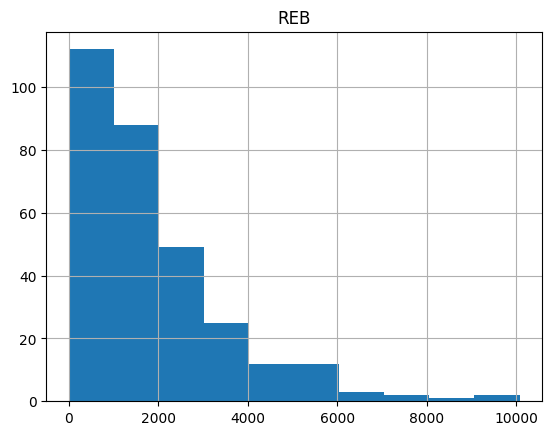

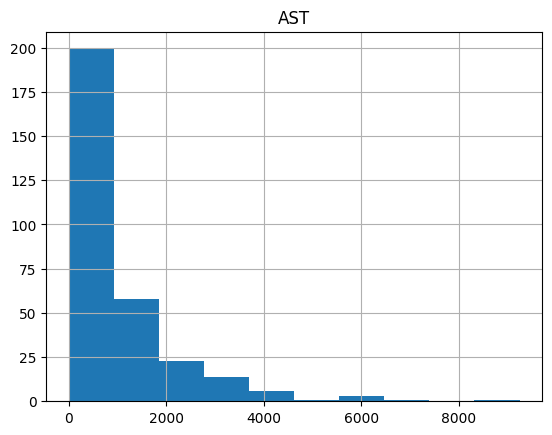

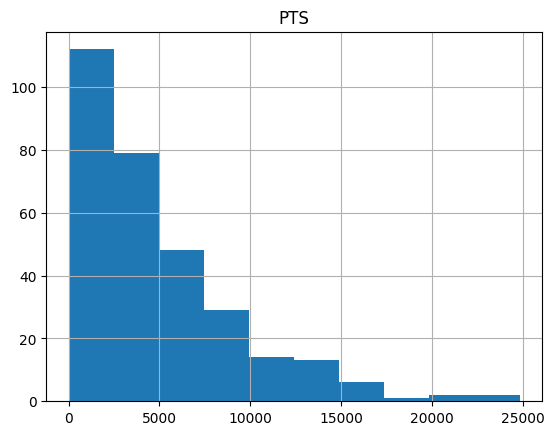

In [ ]:
first_rounders.hist("REB")
first_rounders.hist("AST")
first_rounders.hist("PTS")


Adding a column to see if they are performing above an NBA average for starters and adding 1 if they are. If not they are 0. This is how we changed this into a binary classification problem. 

In [ ]:
average_performance=[]
for index, row in first_rounders.iterrows():
    if ((first_rounders.loc[index]["PTS"]/first_rounders.loc[index]["GP"]) > 15.7 or (first_rounders.loc[index]["REB"]/first_rounders.loc[index]["GP"]) >8 or (first_rounders.loc[index]["AST"]/first_rounders.loc[index]["GP"]) > 7.6 ):
        average_performance.append(1)     
    else:
        average_performance.append(0)
    
    
first_rounders["PERFORMANCE"]=average_performance


C:\Users\suber\AppData\Local\Temp\ipykernel_9272\3991473123.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_rounders["PERFORMANCE"]=average_performance


This uses a for loop to convert the player ID's to names. This uses the NBA_API. We need to do this because now that we have classified the nba players by performance we will then train the model with their college stats dataset. We will also do more cleaning up removing players with insufficient college games. 

In [ ]:
Player_names=[]
for index, row in first_rounders.iterrows():
    ID_player= int(first_rounders.loc[index]['PLAYER_ID'])
    Player_names.append((players.find_player_by_id(ID_player)).get('full_name'))
    
   
first_rounders["NAME"]=Player_names
first_rounders.drop(['PTS','GP','MIN','AST','REB','PLAYER_ID'],axis=1)


C:\Users\suber\AppData\Local\Temp\ipykernel_9272\2939213016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_rounders["NAME"]=Player_names


,PERFORMANCE,NAME
0,1,Zion Williamson
1,1,Ja Morant
2,1,RJ Barrett
3,0,De'Andre Hunter
4,1,Darius Garland
...,...,...
302,0,George Hill
303,0,Darrell Arthur
304,0,Donte Greene
305,0,DJ White


Shows the amount of 0 and 1's in our new column performance

PERFORMANCE
0    241
1     65
Name: count, dtype: int64


c:\Users\suber\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\suber\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\suber\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


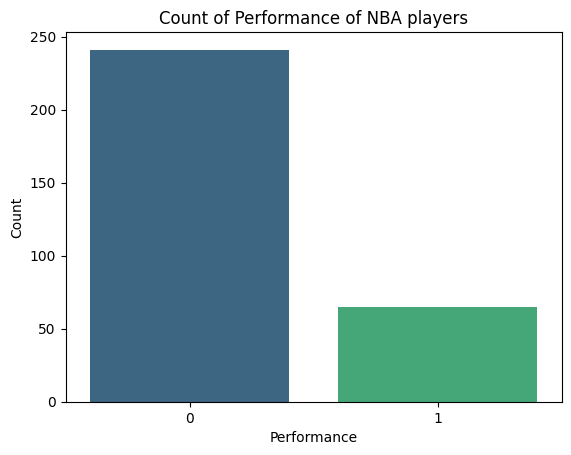

In [ ]:

vc =first_rounders["PERFORMANCE"].value_counts()
print(vc)
sns.countplot(x="PERFORMANCE",data= first_rounders, palette='viridis')

plt.xlabel("Performance")
plt.ylabel('Count')
plt.title('Count of Performance of NBA players')

# Show the plot
plt.show()

This is where we add in the college stats. Also testing out if its indexed the same

In [ ]:

college_excel = pd.read_excel(project_excel)
college_pd = pd.DataFrame(college_excel)
college_pd
first_rounders.loc[0,'NAME']

'Zion Williamson'

Screenshot this is our final data all cleaned up

Finally done have the data with its binary rating 0 or 1 for perfomance and their college stats. Note this dataset is smaller than before because the college datset was filter so players that didnt play enough in college were removed.

In [ ]:

OF_found=[]
PM_found=[]
EFG_found=[]
OR_found = []
DR_found = []
AST_found=[]
TO_found=[]
BLK_found=[]
P_found =[]
name_found=[]
college_nbaperf= pd.DataFrame()
for x, row in first_rounders.iterrows():
    for index, row in college_pd.iterrows():
        if(first_rounders.loc[x,'NAME'])== college_pd.loc[index,'NAME']:
            name_found.append(first_rounders.loc[x,'NAME'])
            P_found.append(first_rounders.loc[x,'PERFORMANCE'])
            OF_found.append(college_pd.loc[index,'O-RATING'])
            PM_found.append(college_pd.loc[index,'PLUS/MINUS'])
            EFG_found.append(college_pd.loc[index,'EFG%'])
            OR_found.append(college_pd.loc[index,'OR%'])
            DR_found.append(college_pd.loc[index,'DR%'])
            AST_found.append(college_pd.loc[index,'AST%'])
            TO_found.append(college_pd.loc[index,'TO%'])
            BLK_found.append(college_pd.loc[index,'BLK%'])

college_nbaperf['NAME']= name_found
college_nbaperf['PERFORMANCE']= P_found 
college_nbaperf['O-RATING']=  OF_found
college_nbaperf['PLUS/MINUS']=PM_found
college_nbaperf['EFG%']=EFG_found
college_nbaperf['OR%']= OR_found
college_nbaperf['DR%']=DR_found
college_nbaperf['AST%']=AST_found
college_nbaperf['TO%']=TO_found
college_nbaperf['BLK%']=BLK_found
college_nbaperf
            


,NAME,PERFORMANCE,O-RATING,PLUS/MINUS,EFG%,OR%,DR%,AST%,TO%,BLK%
0,Zion Williamson,1,129.2,18.7,70.8,12.8,18.0,15.0,15.2,5.8
1,Ja Morant,1,116.9,7.7,53.1,5.3,14.1,42.7,20.5,1.8
2,De'Andre Hunter,0,120.2,9.1,56.4,6.3,13.9,12.6,12.0,2.5
3,Darius Garland,1,110.1,4.6,63.9,1.6,13.7,25.7,23.2,1.5
4,Jarrett Culver,0,108.1,9.2,51.8,5.3,16.8,20.1,15.6,2.6
...,...,...,...,...,...,...,...,...,...,...
230,Quincy Pondexter,0,114.8,6.7,52.0,10.3,13.6,12.0,16.2,1.3
231,Jordan Crawford,0,109.9,7.2,52.3,4.3,11.1,19.5,17.1,0.7
232,Greivis Vasquez,0,106.6,7.3,48.7,3.3,12.4,34.3,20.1,0.9
233,Daniel Orton,0,95.1,3.4,52.7,10.3,16.3,5.0,26.8,10.6


Correlation plot of our college stats

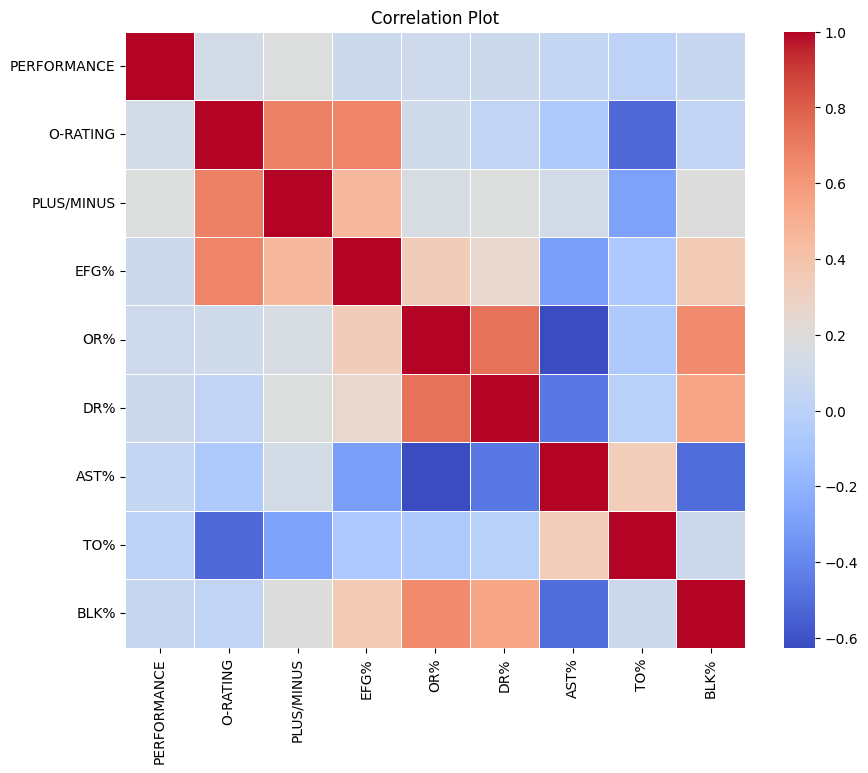

In [ ]:
numeric_columns = college_nbaperf.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Plot")
plt.show()

starting model

In [ ]:
college_nbaperf[["O-RATING","PLUS/MINUS","EFG%","OR%","DR%","AST%","TO%","BLK%","PERFORMANCE"]]

,O-RATING,PLUS/MINUS,EFG%,OR%,DR%,AST%,TO%,BLK%,PERFORMANCE
0,129.2,18.7,70.8,12.8,18.0,15.0,15.2,5.8,1
1,116.9,7.7,53.1,5.3,14.1,42.7,20.5,1.8,1
2,120.2,9.1,56.4,6.3,13.9,12.6,12.0,2.5,0
3,110.1,4.6,63.9,1.6,13.7,25.7,23.2,1.5,1
4,108.1,9.2,51.8,5.3,16.8,20.1,15.6,2.6,0
...,...,...,...,...,...,...,...,...,...
230,114.8,6.7,52.0,10.3,13.6,12.0,16.2,1.3,0
231,109.9,7.2,52.3,4.3,11.1,19.5,17.1,0.7,0
232,106.6,7.3,48.7,3.3,12.4,34.3,20.1,0.9,0
233,95.1,3.4,52.7,10.3,16.3,5.0,26.8,10.6,0


This is our final count for our performance variable. Removed those with little college data.

PERFORMANCE
0    184
1     51
Name: count, dtype: int64


c:\Users\suber\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\suber\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\suber\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


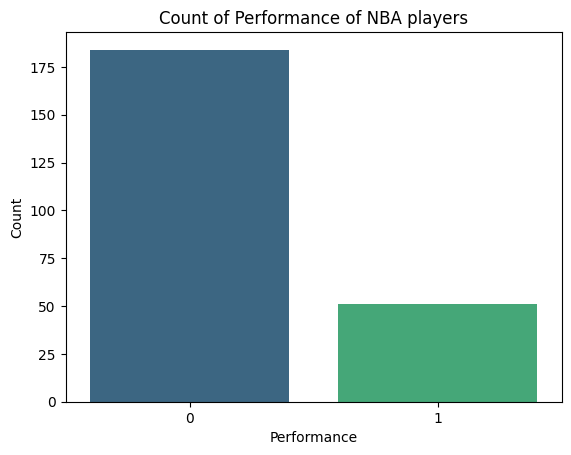

In [ ]:
vc =college_nbaperf["PERFORMANCE"].value_counts()
print(vc)
sns.countplot(x="PERFORMANCE",data= college_nbaperf, palette='viridis')

plt.xlabel("Performance")
plt.ylabel('Count')
plt.title('Count of Performance of NBA players')

# Show the plot
plt.show()

splitting data. We will only be using these stats as predictors in our model

In [ ]:
X= college_nbaperf[["O-RATING","PLUS/MINUS","OR%","DR%","AST%"]]
y = college_nbaperf["PERFORMANCE"]


Here we use stratified k fold becuase our data is imbalanced

In [ ]:
skf= StratifiedKFold(n_splits=5,shuffle=True, random_state=18)
scores=[]
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


Creat model

In [ ]:

log_model=LogisticRegression(random_state=18)


using random search to tun hyperparameters

In [ ]:
penalty =['l1', 'l2','none']
C_vals= [10,1.0,0.1]
max_iter= range(100)
class_weight=['balanced']
param_dist = {
    'max_iter':max_iter,
    'penalty': penalty,
    'C':C_vals,  
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'class_weight':['balanced'],
}
log_model_random = RandomizedSearchCV(
    estimator= log_model, param_distributions=param_dist, n_iter=100, cv=5, random_state=18, scoring='accuracy', n_jobs=-1
)
log_model_random.fit(X_train, y_train)


c:\Users\suber\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
220 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\suber\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\suber\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\suber\AppD

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=18),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [10, 1.0, 0.1],
                                        'class_weight': ['balanced'],
                                        'max_iter': range(0, 100),
                                        'penalty': ['l1', 'l2', 'none'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=18, scoring='accuracy')

Prints our best hyperparameters and the accuracy score of our data

In [ ]:
print("Best hyperparameters: ", log_model_random.best_params_)
best_model = log_model_random.best_estimator_

accuracy = best_model.score(X_test, y_test)
print("Best Accuracy on test set: {:.2f}".format(accuracy))
y_pred = best_model.predict(X_test)


score= accuracy_score(y_test,y_pred)
scores.append(score)
average_score= np.mean(scores)
print(f"average score:{average_score}")


Best hyperparameters:  {'solver': 'lbfgs', 'penalty': 'none', 'max_iter': 38, 'class_weight': 'balanced', 'C': 10}
Best Accuracy on test set: 0.70
average score:0.7021276595744681


creates confusion matrix of our training data

[[27 10]
 [ 4  6]]


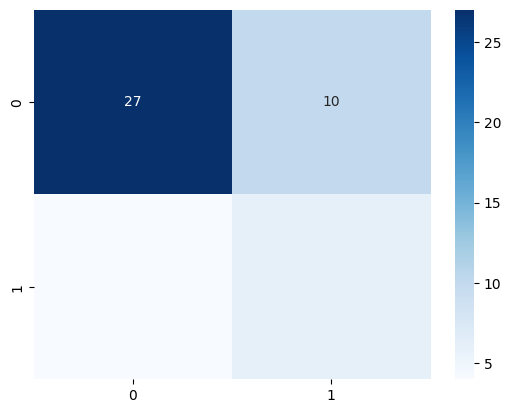

In [ ]:

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

Creates a combined confusion matrix. this is the one we showed on out power point.

Confusion Matrix for Combined Data:


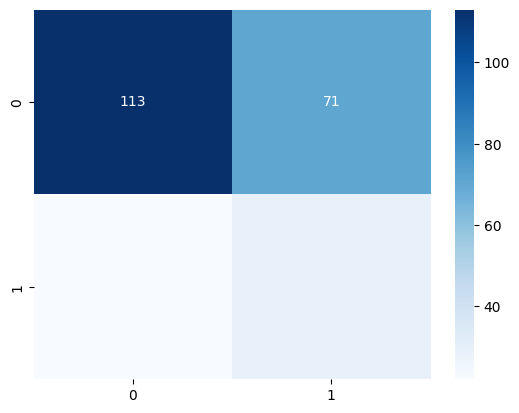

In [ ]:
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])
# Predict on the combined data
y_pred_combined = best_model.predict(X_combined)

# Calculate and print the confusion matrix
cm_combined = confusion_matrix(y_combined, y_pred_combined)
print("Confusion Matrix for Combined Data:")
sns.heatmap(cm_combined, annot=True, fmt="d", cmap="Blues")
plt.show()

This creates our auc which we smoothed

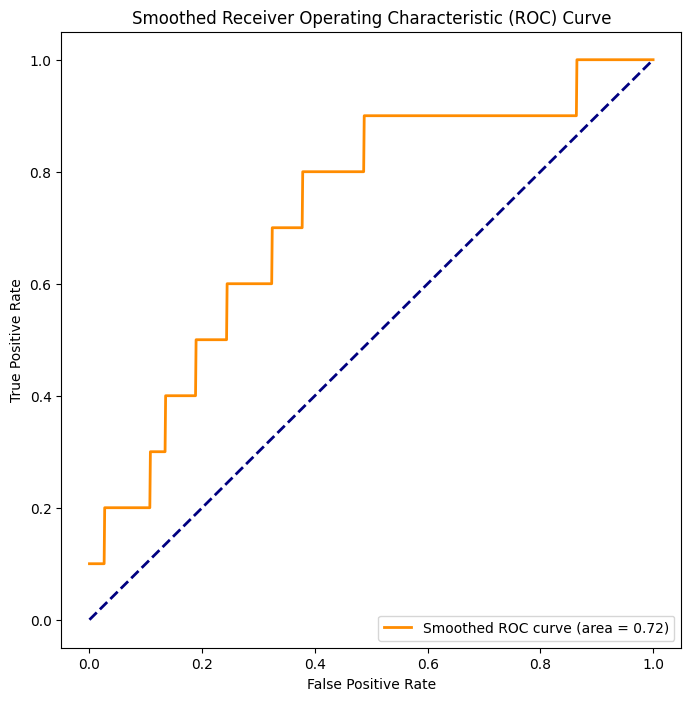

In [ ]:
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Create a smoother ROC curve using interpolation
interp_fpr = np.linspace(0, 1, 1000)
interp_tpr = np.interp(interp_fpr, fpr, tpr)

# Plot the smoothed ROC curve
plt.figure(figsize=(8, 8))
plt.plot(interp_fpr, interp_tpr, color='darkorange', lw=2, label='Smoothed ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Smoothed Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Prints our Auc score

In [ ]:
print('Area under the ROC curve (AUC): {:.2f}'.format(roc_auc))

Area under the ROC curve (AUC): 0.72


makes odds vs predicted probablities graph

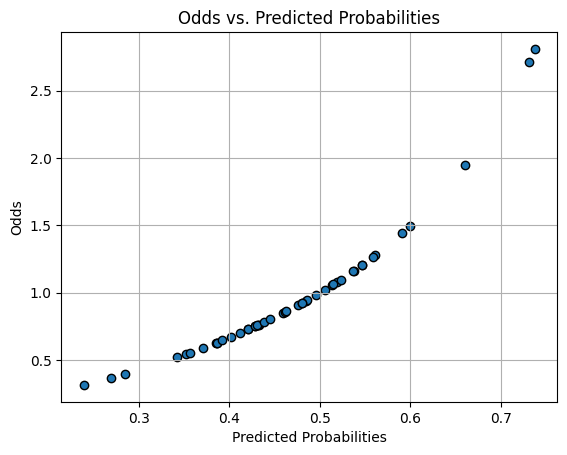

In [ ]:

# Calculate the log-odds for each predicted probability
log_odds = (y_prob / (1 - y_prob))

# Plot the log-odds values
plt.scatter(y_prob, log_odds, edgecolors='k', marker='o')
plt.title('Odds vs. Predicted Probabilities')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Odds')
plt.grid(True)
plt.show()